# Lab 2 Report: 
## MNIST Classification with MLP

In [1]:
# Import necessary packages

import matplotlib.pyplot as plt

import torch
#import torchvision
import numpy as np

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

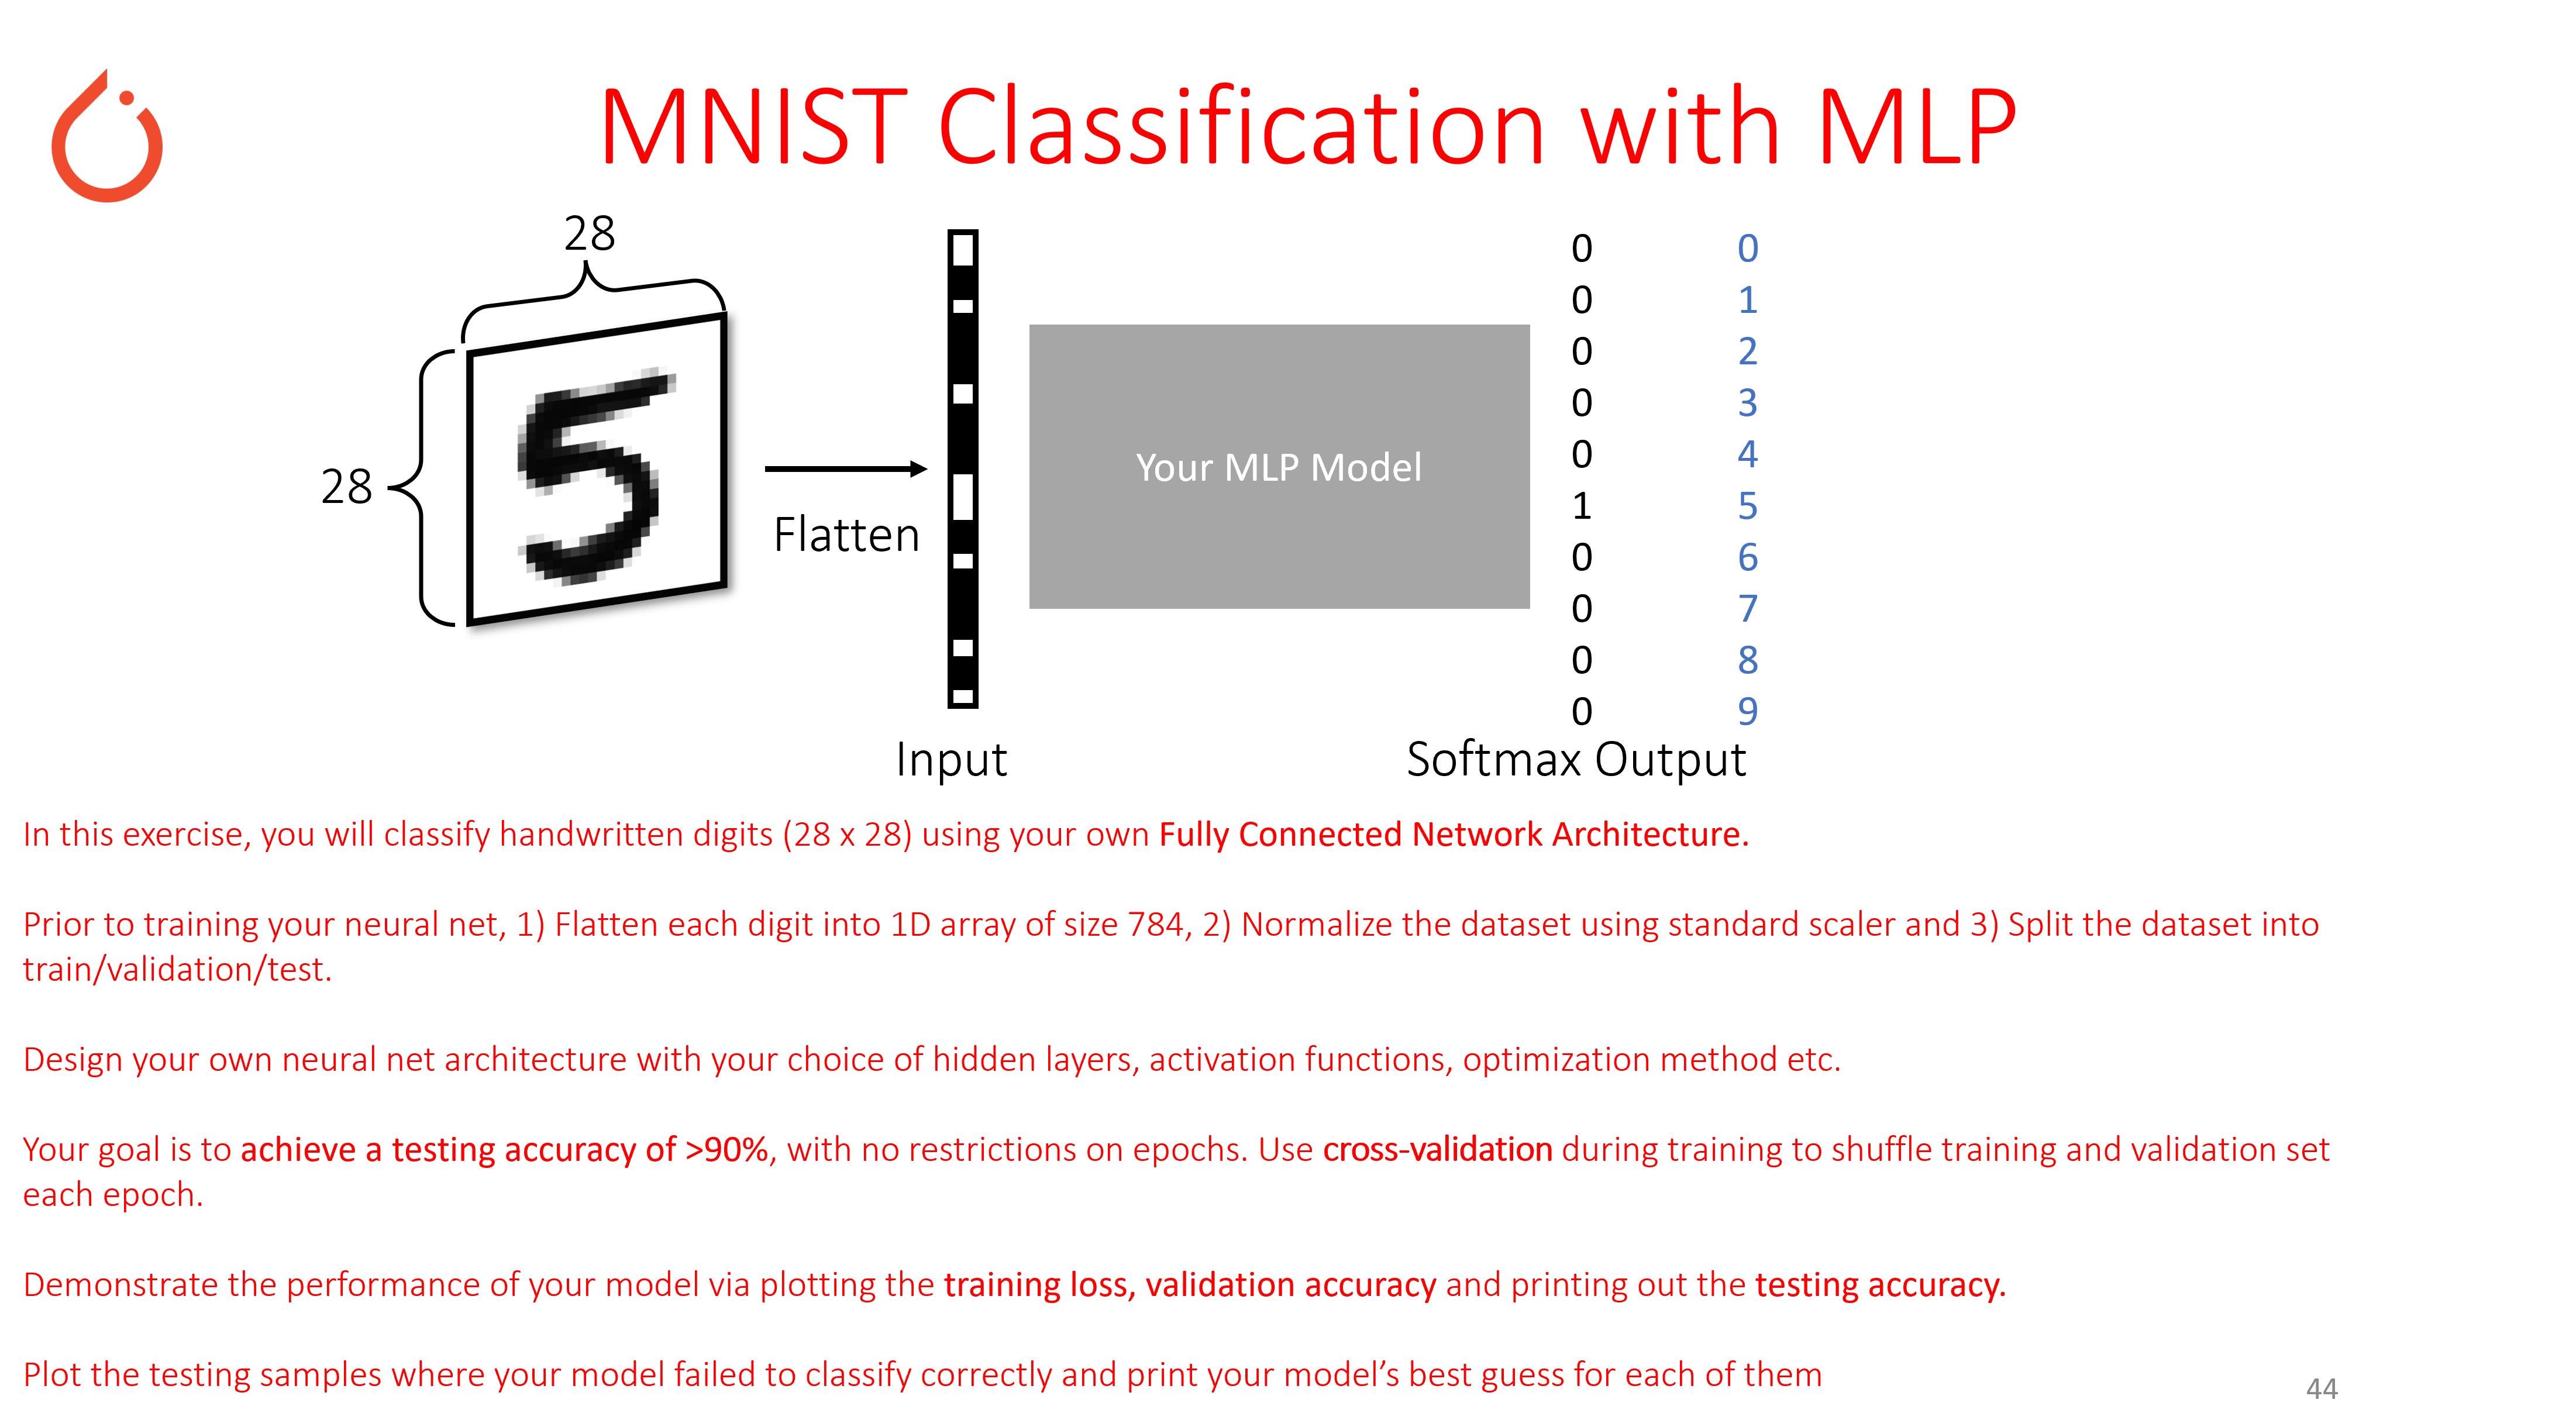

In [3]:
Image('lab2_exercise.PNG', width = 1000)

### Prepare Data

In [4]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy') 
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


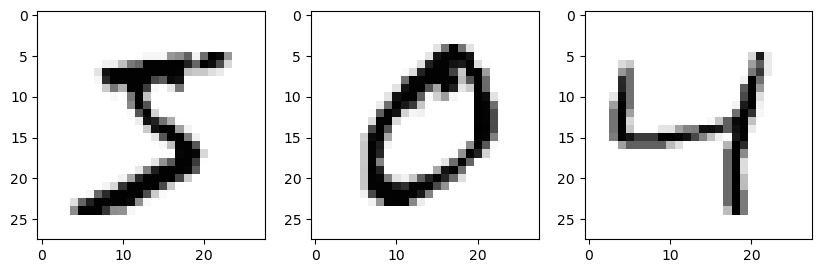

In [5]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

In [6]:
# Reshape features via flattening the images
# The reshaped training/testing features should have shape (1000, 784) and (100, 784) respectively
# np.reshape() function could be useful here

mnist_train_features = np.reshape(mnist_train_features, [1000, 784]) # YOUR CODE HERE
mnist_test_features = np.reshape(mnist_test_features, [100, 784]) # YOUR CODE HERE

print(mnist_train_features.shape, mnist_test_features.shape)

(1000, 784) (100, 784)


In [7]:
# Scale the dataset according to standard scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


mnist_train_features = scaler.fit_transform(mnist_train_features) # YOUR CODE HERE
mnist_test_features = scaler.transform(mnist_test_features) # YOUR CODE HERE

In [8]:
# Initially split dataset into Train (900 samples), Validation (100 samples), Testing (100 samples)
from sklearn.model_selection import train_test_split

mnist_train_features, mnist_validation_features, mnist_train_targets, mnist_validation_targets = train_test_split(mnist_train_features, 
                                                                                                                  mnist_train_targets, 
                                                                                                                  train_size=0.9, 
                                                                                                                  random_state=1)

### Define Model

In [9]:
torch.manual_seed(0)
class mnistClassification(torch.nn.Module):
    
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dim1=512, 
                 hidden_dim2=256):
        
        super(mnistClassification, self).__init__()

        self.input_layer = torch.nn.Linear(input_dim, hidden_dim1)
        self.hidden_layer1 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.output_layer = torch.nn.Linear(hidden_dim2, output_dim)
        self.dropout = torch.nn.Dropout(p=0.2)
        
        # YOUR CODE HERE
        
    def forward(self, x):
        
        # YOUR CODE HERE
        x = torch.nn.functional.relu(self.input_layer(x))
        x = self.dropout(x)
        x = torch.nn.functional.relu(self.hidden_layer1(x))
        x = self.dropout(x)
        out = self.output_layer(x)
        
        return out

### Define Hyperparameters

In [10]:
# Initialize our neural network model with input and output dimensions
model = mnistClassification(784, 10) # YOUR CODE HERE

# Define the learning rate and epoch 
learning_rate = 1e-3 # YOUR CODE HERE
epochs = 100 # YOUR CODE HERE
batchsize = 64 # YOUR CODE HERE (If you are using mini-batch gradient)

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # YOUR CODE HERE

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    model.cuda()

model

mnistClassification(
  (input_layer): Linear(in_features=784, out_features=512, bias=True)
  (hidden_layer1): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Identify Tracked Values

In [11]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = [] # YOUR CODE HERE
validation_accuracy_list = [] # YOUR CODE HERE
train_loss_by_epoch = []

### Train Model

In [12]:
import tqdm
from torch.optim.lr_scheduler import StepLR

patience = 20
best_val_accuracy = 0.0
epochs_without_improvement = 0
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)


# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Shuffle training/validation data each epoch to implement cross-validation

train_inputs = torch.from_numpy(mnist_train_features).float()
train_targets = torch.from_numpy(mnist_train_targets).long()

validation_inputs = torch.from_numpy(mnist_validation_features).float()
validation_targets = torch.from_numpy(mnist_validation_targets).long()

test_inputs = torch.from_numpy(mnist_test_features).float()
test_targets = torch.from_numpy(mnist_test_targets).long()

# Create datasets
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
val_dataset = torch.utils.data.TensorDataset(validation_inputs, validation_targets)

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batchsize, shuffle=True)

    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loss_list.append(loss.item())
    
    train_loss_by_epoch.append(train_loss)


    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += loss_func(val_outputs, val_targets).item()

            predicted = torch.argmax(val_outputs, dim=1)
            true = torch.argmax(val_targets, dim=1) if val_targets.ndim > 1 else val_targets
            correct += (predicted == true).sum().item()
            total += val_targets.size(0)

    # Compute Validation Accuracy ----------------------------------------------------------------------

    accuracy = 100 * correct / total
    validation_accuracy_list.append(accuracy)

    # Update the LR
    scheduler.step()

    # Early stopping check
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break


# if training is going down, but validation going up, stop training


 35%|███▌      | 35/100 [00:08<00:15,  4.32it/s]

Early stopping at epoch 36


### Visualize and Evaluate Model

In [13]:
# Import seaborn for prettier plots

import seaborn as sns

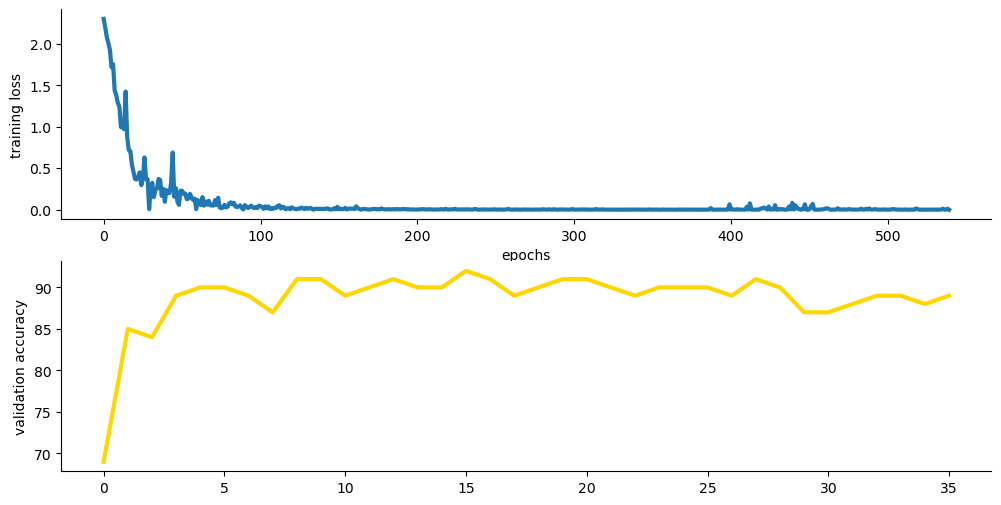

In [14]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [15]:
# Compute the testing accuracy 

# YOUR CODE HERE
with torch.no_grad():
    y_pred_test = model(test_inputs)
    predicted_labels = torch.argmax(y_pred_test, dim=1)

    correct = (predicted_labels == test_targets).type(torch.FloatTensor)
    print(f'Testing Accuracy: {correct.mean().numpy()*100}%')

Testing Accuracy: 93.0%


Total incorrect predictions: 7


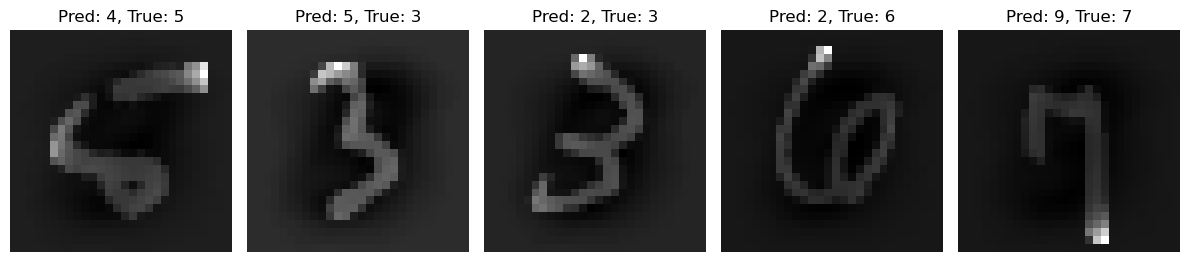

In [16]:
# Plot 5 incorrectly classified testing samples and print the model predictions for each of them
# You can use np.reshape() to convert flattened 1D array (768,) -> (28, 28)

# YOUR CODE HERE
incorrect_indices = (predicted_labels != test_targets).nonzero(as_tuple=True)[0]
print(f"Total incorrect predictions: {len(incorrect_indices)}")

num_to_show = 5
samples_to_plot = incorrect_indices[:num_to_show]

plt.figure(figsize=(12, 4))
for i, idx in enumerate(samples_to_plot):
    img = test_inputs[idx].reshape(28, 28)  # reshape back to 28x28
    true_label = test_targets[idx].item()
    pred_label = predicted_labels[idx].item()

    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

